# Decision boundaries usign Supervised decision boundary maps (SDBM)

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import tqdm

from itertools import permutations

from sklearn.utils.extmath import cartesian

import torch
import torch.nn as nn
import torch.nn.functional as F

from NegativeClassOptimization import decision_boundaries, config
from NegativeClassOptimization import utils
from NegativeClassOptimization import preprocessing
from NegativeClassOptimization import datasets

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
def get_model_from_task(task):
    if type(task.model) == torch.optim.swa_utils.AveragedModel:
    # Unwrap the SWA model. We need a module class,
    # that has updated weights, but still has other
    # module funcs, such as forward_logits.
    # Note: swa_model.module has same weights as swa_model.state_dict().
        return task.model.module
    else:
        return task.model

In [17]:
loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
)

task = datasets.ClassificationTask(
        task_type=datasets.ClassificationTaskType.ONE_VS_ONE,
        ag_pos="3VRL",
        ag_neg="1NSN",
        seed_id=0,
        split_id=42,
    )
            
task = loader.load(task, attributions_toload="v2.0-2", load_model=True)

In [18]:
task.test_dataset = preprocessing.onehot_encode_df(task.test_dataset)
task.test_dataset["X"] = task.test_dataset["Slide_onehot"]

X = np.stack(task.test_dataset["X"])
y = task.test_dataset["y"].astype(float)

In [19]:
# Based on experiment_blobs.py

output_dir = Path("07i_decision_boundaries")
dataset_name = "test_1adq"
epochs = 30  # 200
patience = 5
verbose = False


n_samples = X.shape[0]
n_classes = len(np.unique(y))

X_ssnpgt_proj_file = f'X_SSNP_{dataset_name}.npy'
name_projector_ssnp = f"{dataset_name}_ssnp"

ssnpgt = decision_boundaries.SSNP(
    epochs=epochs, 
    verbose=verbose, 
    patience=patience, 
    opt='adam', 
    bottleneck_activation='linear'
)

if (output_dir / name_projector_ssnp).exists():
    ssnpgt.load_model(output_dir / name_projector_ssnp)
else: #otherwise it will be fitted
    ssnpgt.fit(X, y)
    ssnpgt.save_model(output_dir / name_projector_ssnp)

2024-03-21 20:01:57.660507: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-03-21 20:01:57.679190: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3199865000 Hz
2024-03-21 20:02:32.932784: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: 07i_decision_boundaries/test_1adq_ssnp/assets


In [20]:
if os.path.exists(os.path.join(output_dir, X_ssnpgt_proj_file)):
    print(
        f"Projected SSNP points found! {os.path.join(output_dir,X_ssnpgt_proj_file)}"
    )
    X_ssnpgt = np.load(os.path.join(output_dir, X_ssnpgt_proj_file))
else:
    print("Projected SSNP points not found! Transforming...")
    X_ssnpgt = ssnpgt.transform(X)
    np.save(os.path.join(output_dir, X_ssnpgt_proj_file), X_ssnpgt)
    print(f"Projected points ({dataset_name}) saved.")

Projected SSNP points not found! Transforming...
Projected points (test_1adq) saved.


In [21]:
clf = get_model_from_task(task)
clf_name = "SN10"
grid_size = 300


ssnp_done = False
out_name = f"{clf_name}_{grid_size}x{grid_size}_{dataset_name}"
out_file = os.path.join(output_dir, out_name + "_ssnp.npy")

if os.path.exists(out_file):
    img_grid_ssnp = np.load(
        os.path.join(output_dir, out_name + "_ssnp.npy")
    )
    prob_grid_ssnp = np.load(
        os.path.join(output_dir, out_name + "_ssnp_prob" + ".npy")
    )
    prob_grid_ssnp = prob_grid_ssnp.clip(max=0.8)

    # Background mode
    normalized = None
    suffix = "ssnp_background"

    decision_boundaries.results_to_png(
        np_matrix=img_grid_ssnp,
        prob_matrix=prob_grid_ssnp,
        grid_size=grid_size,
        n_classes=n_classes,
        real_points=normalized,
        max_value_hsv=0.8,
        dataset_name=dataset_name,
        classifier_name=clf_name,
        suffix=suffix,
        output_dir=output_dir,
    )

else:

    print("Defining grid around projected 2D points.")
    xmin_ssnp = np.min(X_ssnpgt[:, 0])
    xmax_ssnp = np.max(X_ssnpgt[:, 0])
    ymin_ssnp = np.min(X_ssnpgt[:, 1])
    ymax_ssnp = np.max(X_ssnpgt[:, 1])

    x_intrvls_ssnp = np.linspace(xmin_ssnp, xmax_ssnp, num=grid_size)
    y_intrvls_ssnp = np.linspace(ymin_ssnp, ymax_ssnp, num=grid_size)

    x_grid = np.linspace(0, grid_size - 1, num=grid_size)
    y_grid = np.linspace(0, grid_size - 1, num=grid_size)

    pts_ssnp = cartesian((x_intrvls_ssnp, y_intrvls_ssnp))
    pts_grid = cartesian((x_grid, y_grid))
    pts_grid = pts_grid.astype(int)

    batch_size = min(grid_size**2, 10000)

    # Can probably be moved lower, here not used
    img_grid_ssnp = np.zeros((grid_size, grid_size))
    prob_grid_ssnp = np.zeros((grid_size, grid_size))

    pbar = tqdm.tqdm(total=len(pts_ssnp))
    position = 0

    # Iterate over all points in the 2D-grid 
    while True:
        if position >= len(pts_ssnp):
            break

        pts_batch_ssnp = pts_ssnp[position : position + batch_size]
        image_batch_ssnp = ssnpgt.inverse_transform(pts_batch_ssnp)

        probs_ssnp = clf.predict(torch.tensor(image_batch_ssnp)).detach().numpy()
        alpha_ssnp = np.amax(probs_ssnp, axis=1)
        labels_ssnp = probs_ssnp.argmax(axis=1)

        pts_grid_batch = pts_grid[position : position + batch_size]

        img_grid_ssnp[
            pts_grid_batch[:, 0],  # First column
            pts_grid_batch[:, 1],  # Second column
        ] = labels_ssnp

        position += batch_size

        prob_grid_ssnp[
            pts_grid_batch[:, 0],  # First column
            pts_grid_batch[:, 1],  # Second column
        ] = alpha_ssnp

        pbar.update(batch_size)

    pbar.close()
    np.save(os.path.join(output_dir, f"{out_name}_ssnp.npy"), img_grid_ssnp)
    np.save(
        os.path.join(output_dir, f"{out_name}_ssnp_prob.npy"), prob_grid_ssnp
    )

    prob_grid_ssnp = prob_grid_ssnp.clip(max=0.8)

    # Background mode
    normalized = None
    suffix = "ssnp_background"

    decision_boundaries.results_to_png(
        np_matrix=img_grid_ssnp,
        prob_matrix=prob_grid_ssnp,
        grid_size=grid_size,
        n_classes=n_classes,
        real_points=normalized,
        max_value_hsv=0.8,
        dataset_name=dataset_name,
        classifier_name=clf_name,
        suffix=suffix,
        output_dir=output_dir,
    )

Defining grid around projected 2D points.


  0%|          | 0/90000 [00:00<?, ?it/s]

100%|██████████| 90000/90000 [00:04<00:00, 19549.15it/s]


Saving vanilla. 300x300 - test_1adq - SN10
Saving alpha. 300x300 - test_1adq - SN10
Saving hsv. 300x300 - test_1adq - SN10


We computed the above for all the tasks using script 17. Now we collect all the plots to check them.
Blue indicates positive class!

In [8]:
# def task_generator(loader=loader):
#     """
#     Generate tasks for which to compute attributions.
#     """
#     task_types = [
#         datasets.ClassificationTaskType.HIGH_VS_LOOSER,
#         datasets.ClassificationTaskType.HIGH_VS_95LOW,
#         datasets.ClassificationTaskType.ONE_VS_NINE,
#         datasets.ClassificationTaskType.ONE_VS_ONE,
#     ]
#     seed_split_ids = datasets.FrozenMiniAbsolutMLLoader.generate_seed_split_ids()
#     for ag_1, ag_2 in permutations(config.ANTIGENS, r=2):
#         for seed_id, split_id in seed_split_ids:
#             for task_type in task_types:
#                 if task_type == datasets.ClassificationTaskType.ONE_VS_ONE:
#                     task = datasets.ClassificationTask(
#                         task_type=task_type,
#                         ag_pos=ag_1,
#                         ag_neg=ag_2,
#                         seed_id=seed_id,
#                         split_id=split_id,
#                     )
#                 else:
#                     task = datasets.ClassificationTask(
#                         task_type=task_type,
#                         ag_pos=ag_1,
#                         ag_neg="auto",
#                         seed_id=seed_id,
#                         split_id=split_id,
#                     )
#                 yield task

# tasks = list(task_generator())

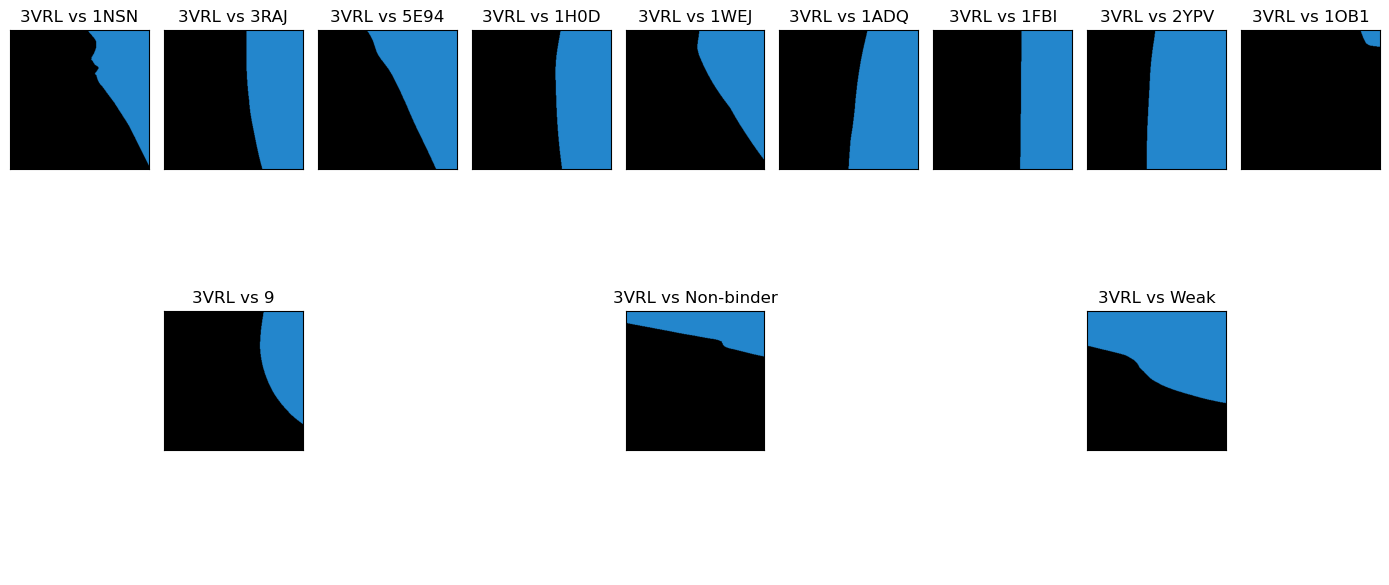

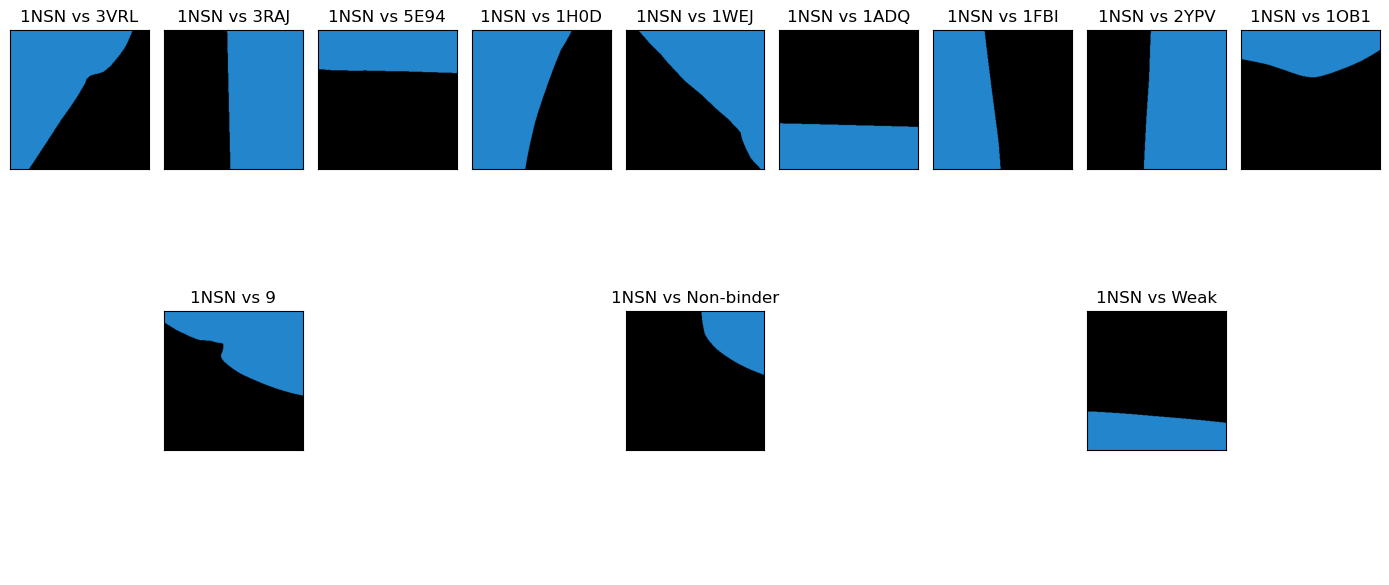

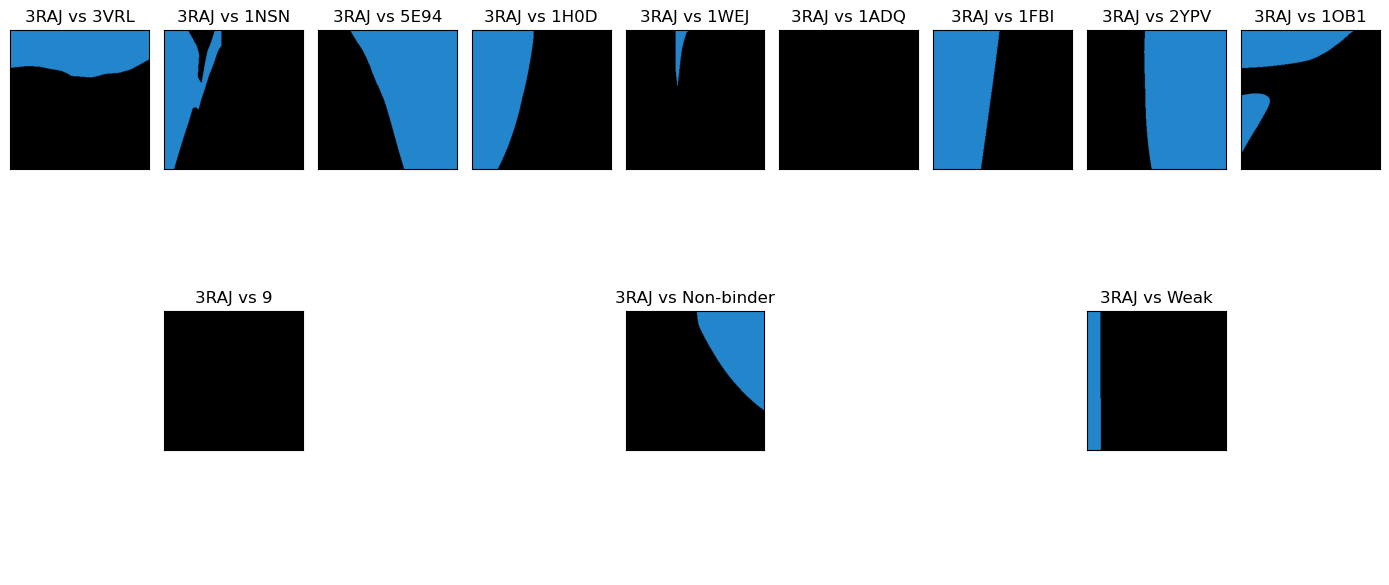

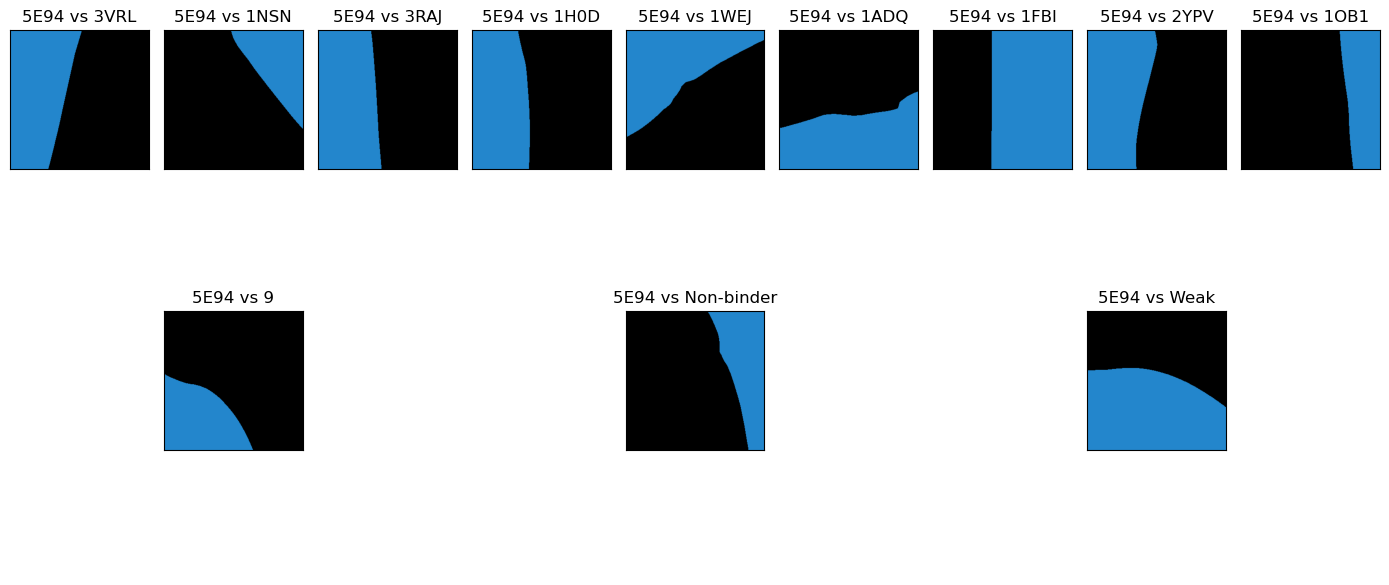

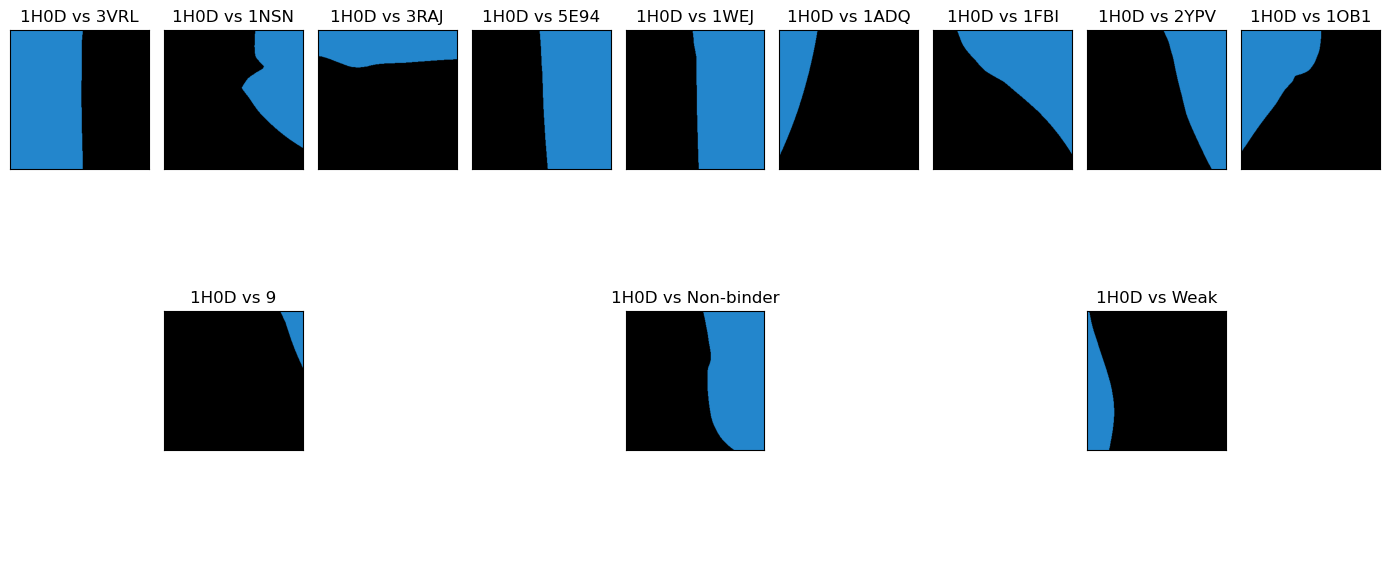

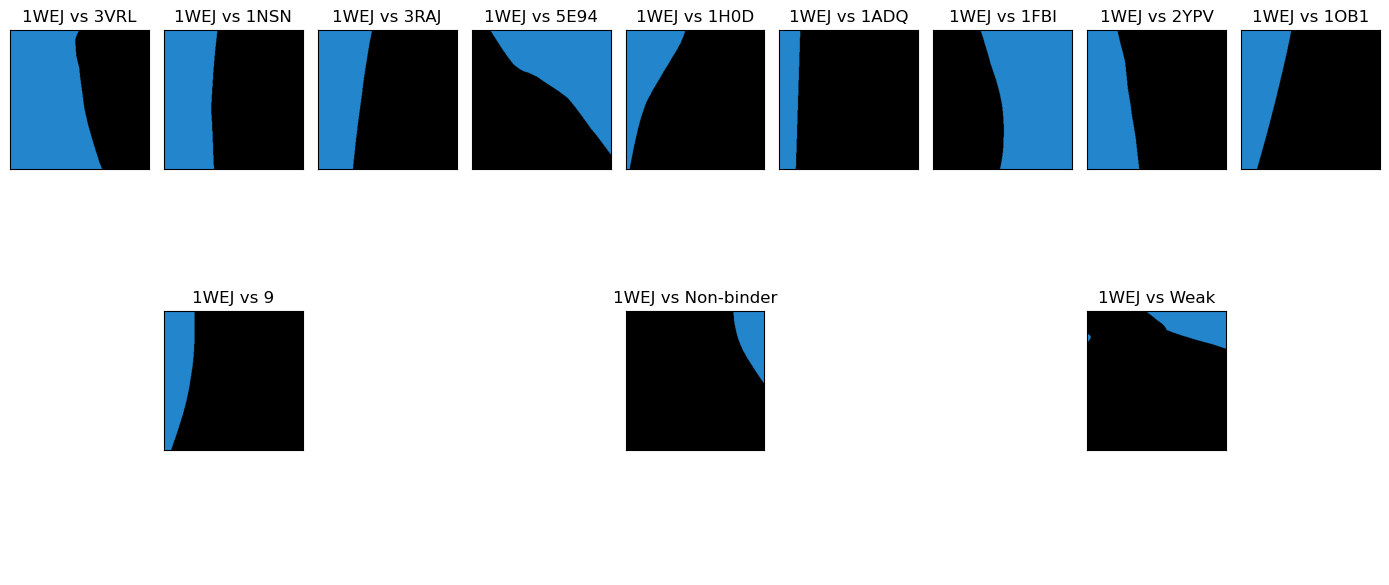

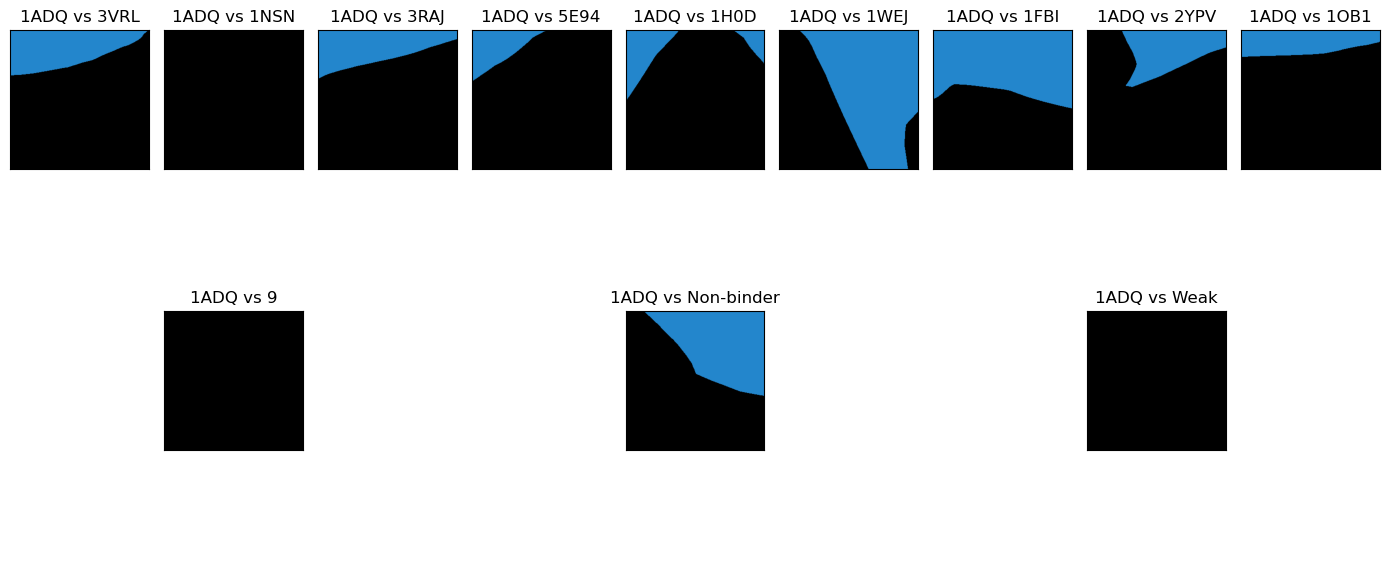

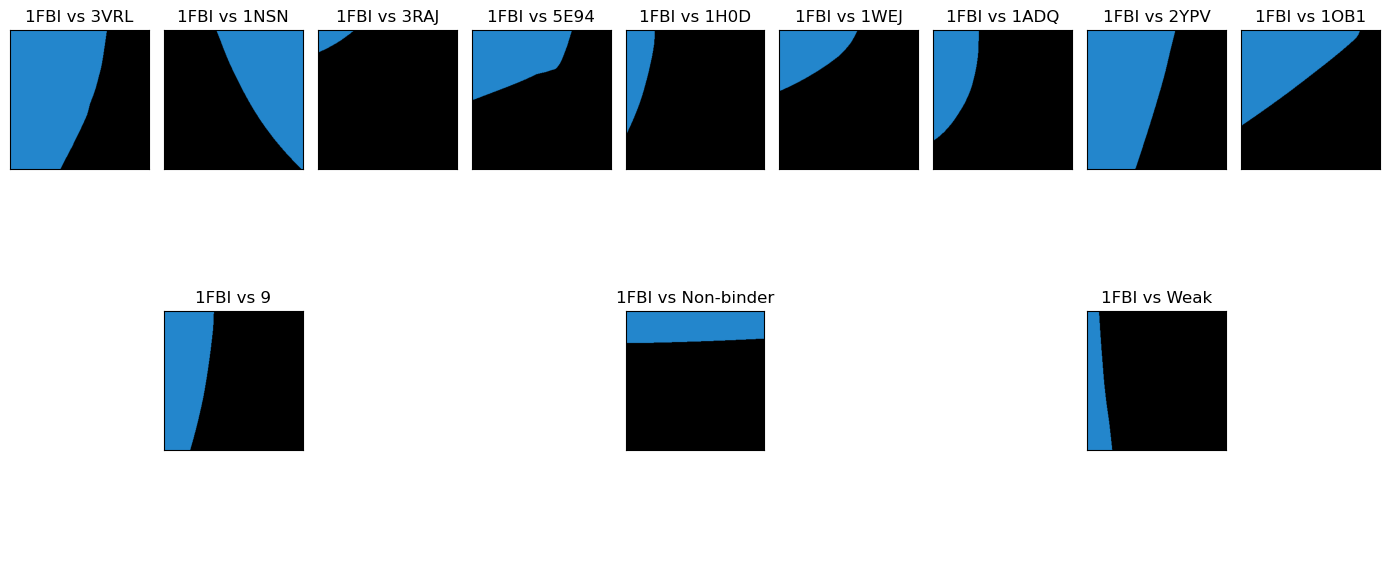

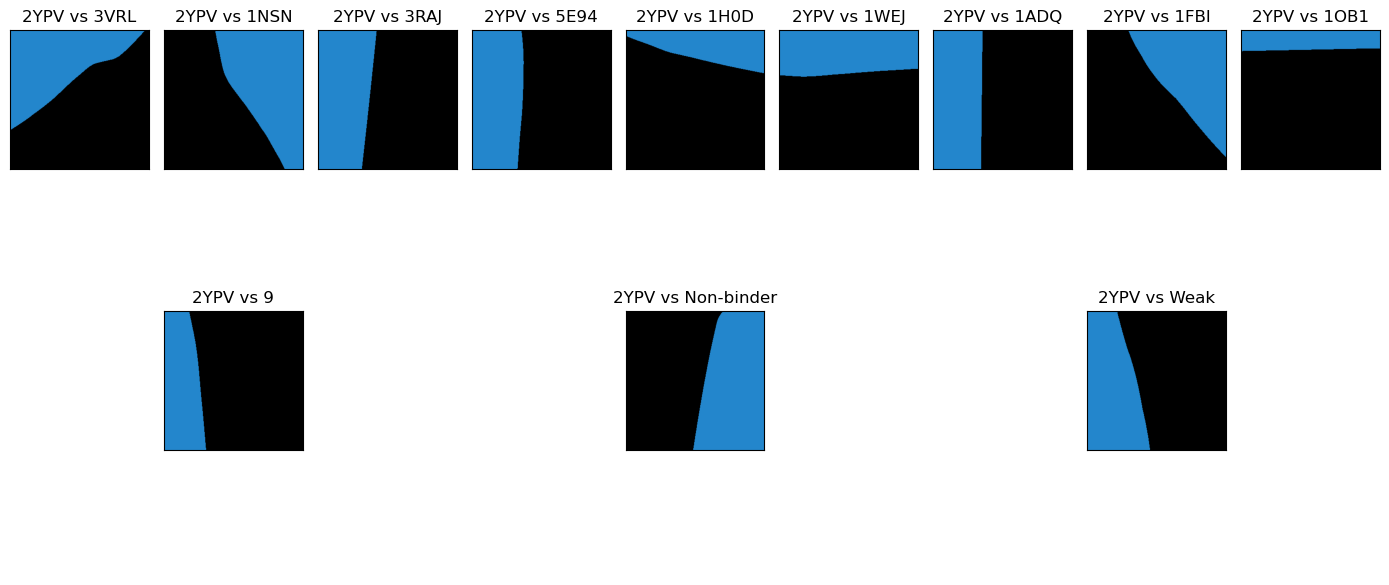

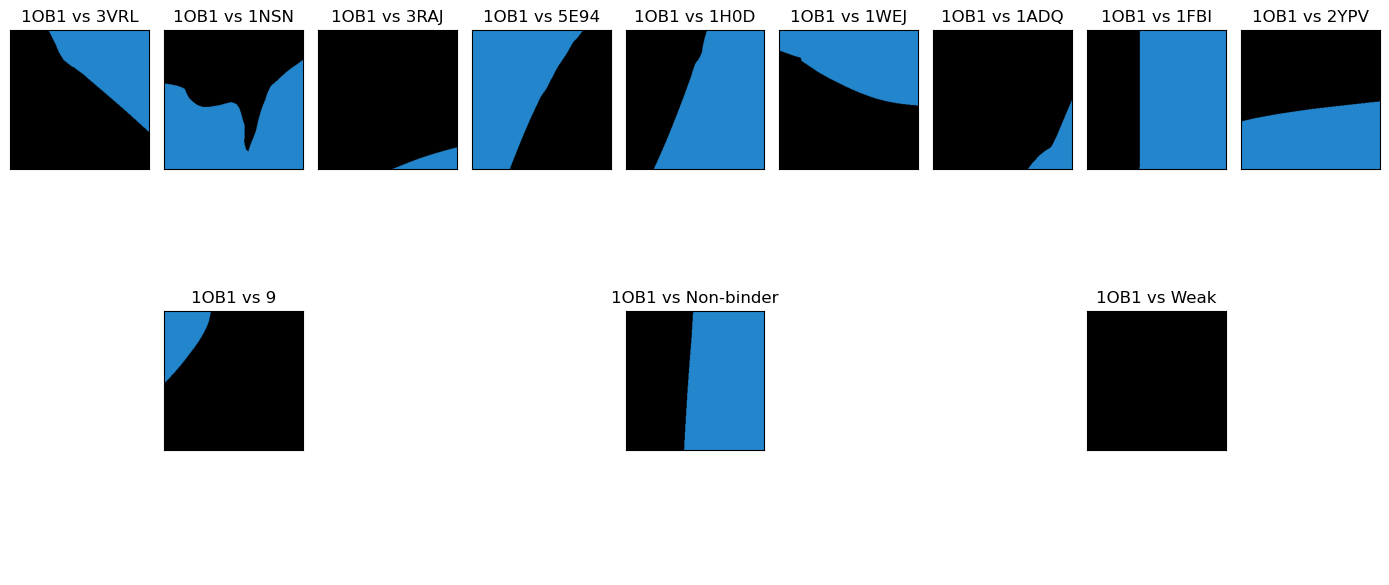

In [15]:
# from matplotlib.backends.backend_pdf import PdfPages

# plt.rcParams["figure.figsize"] = [7.00, 3.50] 
# plt.rcParams["figure.autolayout"] = True

# # PdfPages is a wrapper around pdf  
# # file so there is no clash and 
# # create files with no error. 
# p = PdfPages("test.pdf") 

# tasks = list(filter(lambda t: t.seed_id == 0 and t.split_id == 42, tasks))

# for ag in config.ANTIGENS:

#     tasks_ag = filter(lambda t: t.ag_pos == ag, tasks)

#     fig, axs = plt.subplots(nrows=2, ncols=9, figsize=(14, 7))

#     counter_1v1 = 0
#     for task in tasks_ag:

#         task = loader.load(task)
#         base_path = task.basepath
#         img_path = base_path / "SDBM/SN10_300x300_SDBM_hsv_ssnp_background.png"
    
#         if img_path.exists():
#             img = plt.imread(img_path)

#         # Select ax based on task_type
#         if task.task_type == datasets.ClassificationTaskType.ONE_VS_ONE:
#             ax = axs[0, counter_1v1]
#             counter_1v1 += 1
#             title = f"{task.ag_pos} vs {task.ag_neg}"

#         elif task.task_type == datasets.ClassificationTaskType.ONE_VS_NINE:
#             ax = axs[1, 1]
#             title = f"{task.ag_pos} vs 9"
#         elif task.task_type == datasets.ClassificationTaskType.HIGH_VS_95LOW:
#             ax = axs[1, 4]
#             title = f"{task.ag_pos} vs Non-binder"
#         elif task.task_type == datasets.ClassificationTaskType.HIGH_VS_LOOSER:
#             ax = axs[1, 7]
#             title = f"{task.ag_pos} vs Weak"

#         # Figure from img
#         ax.imshow(img)
#         ax.set_title(title)

#     # Make all the unused axes invisible
#     for ax in axs.flatten():
#         if not ax.get_title():
#             ax.axis("off")
#         else:
#             ax.axis("on")

#     # Remove x and y ticks and labels
#     for ax in axs.flatten():
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_xlabel("")
#         ax.set_ylabel("")

#     # and saving the files 
#     fig.savefig(p, format='pdf')
        
# # close the object 
# p.close()   

Next we further develop the plots, to display at least a sample of the data points as well.

We need a consistent way to:
- do the pixels
- map points to pixel space on top (like a scatterplot!)

In [35]:
from PIL import Image
import matplotlib.cm as cm
from skimage.color import rgb2hsv, hsv2rgb


array([[0. , 0. , 0. , ..., 0.8, 0.8, 0.8],
       [0. , 0. , 0. , ..., 0.8, 0.8, 0.8],
       [0. , 0. , 0. , ..., 0.8, 0.8, 0.8],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [36]:
prob_grid_ssnp

array([[0. , 0. , 0. , ..., 0.8, 0.8, 0.8],
       [0. , 0. , 0. , ..., 0.8, 0.8, 0.8],
       [0. , 0. , 0. , ..., 0.8, 0.8, 0.8],
       ...,
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [ ]:
im.save(
    os.path.join(
        output_dir,
        f"{classifier_name}_{grid_size}x{grid_size}_{dataset_name}_custom{suffix}.png",
    )
)